In [1]:
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from planet import planet
from phantom_brainweb import mr_brain_web_phantom, brain_web_loader,offres_gen, mr_brain_web_SNR

In [14]:
# Function to split real and imaginary part of complex data into individual element of an array
def split_complex_data(data):
    split_data = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        split_data[:,2*i] = data[:,i].real
        split_data[:,2*i+1] = data[:,i].imag
    return split_data

# Function to split testing data according the type of tissue
def split_t2_tissues(data):
    csf_test = [] # T2 = 1.99
    gm_test = []  # T2 = 0.1
    wm_test = [] # T2 = 0.08

    for i in range(len(data)):
        if gt_test[i] == 1.99:
            csf_test.append(data[i,:])

        if gt_test[i] == 0.1:
            gm_test.append(data[i,:])
        
        if gt_test[i] == 0.08:
            wm_test.append(data[i,:])

    csf_test = np.asarray(csf_test)
    gm_test  = np.asarray(gm_test)
    wm_test  = np.asarray(wm_test)
    return csf_test, gm_test, wm_test

# Function for Monte Carlo Simulation
def monte_carlo(data):
    pdf = [] #empty list to store probability value
    result = 0

    # Neural network
    if data.shape[1] == 12:
        predicted_t2 = model.predict(data)

    # PLANET
    if data.shape[1] == 6:
        predicted_t2 = np.zeros((len(data),1))
        TR = 3e-3 # TR = relaxation time
        npcs = 6  # npcs = no. of phase cycles, 
        B0 = 3   # B0 =main magnetic field
        alpha = np.deg2rad(30) # alpha = flip angle
        pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
        for i in range(len(data)):
            _, _,predicted_t2[i] = planet(data[i], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, compute_df=False)
    
    # for i in range(len(predicted_t2)):
    #     result = result + predicted_t2[i]
    #     pdf.append(result/(i+1)) #append result of each iteration to the empty list

    #pdf  = np.asarray(pdf)

    return predicted_t2.mean(), predicted_t2.std(), predicted_t2

In [4]:
# Load voxel and ground truth t2 data
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

# Split training and test set, 1%
test_size = 100
voxel_test = voxel_train[-test_size:, :]
gt_test = gt_train[-test_size:,:]
voxel_train = voxel_train[:-test_size,:]
gt_train = gt_train[:-test_size,:]

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [ 1.10504396e-01-0.03675562j  1.11785755e-01+0.06240179j
 -4.11207267e-02+0.16652692j -3.45971103e-02+0.11180743j
 -7.54686890e-05-0.01720659j  9.22913561e-02-0.11036255j]
Ground Truth T2: [0.1]


In [5]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:')
print(new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts:
[ 1.10504396e-01 -3.67556171e-02  1.11785755e-01  6.24017861e-02
 -4.11207267e-02  1.66526920e-01 -3.45971103e-02  1.11807429e-01
 -7.54686890e-05 -1.72065882e-02  9.22913561e-02 -1.10362548e-01]


In [88]:
# Define the network structure
inputs = tf.keras.Input(shape=(12,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [89]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
891/891 [==============================] - 1s 1ms/step - loss: 0.1256 - mse: 0.1256 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 2/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/10
891/891 [==============================] - 1s 1ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 8/10
891/891 [==============================] - 1s 1ms/step - loss: 0.

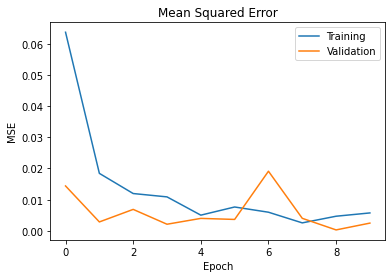

10/10 [==============================] - 0s 661us/step - loss: 5.0291e-04 - mse: 5.0291e-04
Test MSE: 0.0005029061576351523


In [90]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print('Test MSE:',test_metric[1])

In [6]:
# Save or load trained model 
#model.save('voxel_regression'); 
model = tf.keras.models.load_model('voxel_regression');

In [7]:
# Split testing data into corresponding tissues
csf_test, gm_test, wm_test = split_t2_tissues(voxel_test)
new_csf_test, new_gm_test, new_wm_test = split_t2_tissues(new_voxel_test)

In [16]:
# PLANET : Monte Carlo
# mean_csf_t2_p, std_csf_t2_p, csf_pdf_p = monte_carlo(csf_test)
# print('PLANET Mean T2 (CSF)', mean_csf_t2_p) 
# mean_gm_t2_p, std_gm_t2_p, gm_pdf_p = monte_carlo(gm_test)
# print('PLANET Mean T2 (GM)', mean_gm_t2_p)
# mean_wm_t2_p, std_wm_t2_p, wm_pdf_p = monte_carlo(wm_test)
# print('PLANET Mean T2 (WM)', mean_wm_t2_p)

Text(0, 0.5, 'Probability')

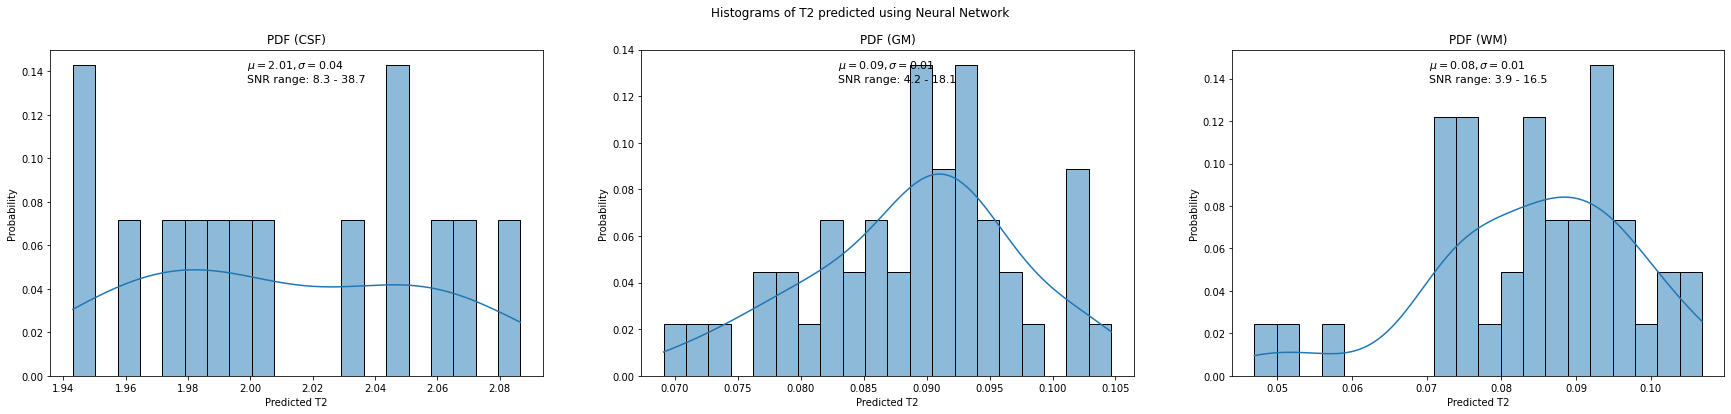

In [105]:
# Neural network : Monte Carlo
mean_csf_t2, std_csf_t2, csf_pdf = monte_carlo(new_csf_test) 
mean_gm_t2, std_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, std_wm_t2, wm_pdf = monte_carlo(new_wm_test)

# Plotting of histograms
snr_data = np.load('snr_train.npy')
s = '\n'
csf_str = s.join(['$\mu = %.2f , \sigma = %.2f$'%(mean_csf_t2,std_csf_t2), 'SNR range: %.1f - %.1f'%(snr_data[0],snr_data[1])])
gm_str = s.join(['$\mu = %.2f , \sigma = %.2f$'%(mean_gm_t2,std_gm_t2), 'SNR range: %.1f - %.1f'%(snr_data[2],snr_data[3])])
wm_str = s.join(['$\mu = %.2f , \sigma = %.2f$'%(mean_wm_t2,std_wm_t2), 'SNR range: %.1f - %.1f'%(snr_data[4],snr_data[5])])
textbox_height = 0.9
textbox_width  = 0.4
bins = 20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
fig.suptitle('Histograms of T2 predicted using Neural Network')
# CSF 
sns.histplot(data=csf_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax1)
ax1.set_title('PDF (CSF)')
ax1.text(textbox_width, textbox_height,csf_str,fontsize=11,transform=ax1.transAxes)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')

# GM
sns.histplot(data=gm_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax2)
ax2.set_title('PDF (GM)')
ax2.text(textbox_width, textbox_height,gm_str,fontsize=11,transform=ax2.transAxes)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')

# WM
sns.histplot(data=wm_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax3)
ax3.set_title('PDF (WM)')
ax3.text(textbox_width, textbox_height,wm_str,fontsize=11,transform=ax3.transAxes)
ax3.set_xlabel('Predicted T2')
ax3.set_ylabel('Probability')